<a href="https://colab.research.google.com/github/vandanacm/resume-classifier/blob/main/resume_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [1]:
!pip install -q emoji wordcloud textblob datasets tf-keras xgboost
import warnings
warnings.filterwarnings('ignore')

import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
import nltk
from tqdm import tqdm
from collections import Counter
from IPython.display import display
from google.colab import drive

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

from wordcloud import WordCloud
from textblob import TextBlob

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix,
    precision_recall_curve, average_precision_score, PrecisionRecallDisplay,
    f1_score, recall_score
)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)
from IPython.display import display
from datasets import Dataset

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Exploratory Data Analysis (EDA)

In [3]:
data_path= "/content/drive/My Drive/Colab Notebooks/Resume.csv"
data_df= pd.read_csv(data_path)
print(data_df.shape)
data_df.head()

(2484, 4)


ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR  
3  <div class="fontsize fontface vmargins hmargin...       HR  
4  <div class="fontsize fontface vmargins hmargin...       HR

**Data description:**<br>
The dataset is arranged in a `.csv` file. This dataset contains 4 columns. They are described as, <br>
* ID: Unique identifier and file name for the respective resume.
* Resume_str : Contains the resume text only in string format.
* Resume_html : Contains the resume data in html format as present while web scrapping.
* Category : Category of resume.


There are `2484` resumes in total in the dataset. The dataset is small in size. `Training bigger model will be an issue as they needs bigger dataset and tends to overfit.`

In [4]:
display(data_df.columns)

print(f"Total no of resumes in the dataset: {len(data_df)}")

Index(['ID', 'Resume_str', 'Resume_html', 'Category'], dtype='object')

Total no of resumes in the dataset: 2484


For our task we don't need `Resume_html` column. So, we will drop it. Then we will explore the dataset.

In [5]:
data_df.drop(columns= ["Resume_html"], axis= 1, inplace= True)
data_df.head()

ID                                         Resume_str Category
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...       HR
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...       HR
2  33176873           HR DIRECTOR       Summary      Over 2...       HR
3  27018550           HR SPECIALIST       Summary    Dedica...       HR
4  17812897           HR MANAGER         Skill Highlights  ...       HR

In [6]:
display(data_df.isnull().sum())

ID            0
Resume_str    0
Category      0
dtype: int64

There is no missing value which is good.<br>

Lets explore the categories and their distribution

In [7]:
categories= sorted(data_df['Category'].unique())
print(f"Total no of categories are: {len(categories)}")

display(categories)

Total no of categories are: 24


['ACCOUNTANT',
 'ADVOCATE',
 'AGRICULTURE',
 'APPAREL',
 'ARTS',
 'AUTOMOBILE',
 'AVIATION',
 'BANKING',
 'BPO',
 'BUSINESS-DEVELOPMENT',
 'CHEF',
 'CONSTRUCTION',
 'CONSULTANT',
 'DESIGNER',
 'DIGITAL-MEDIA',
 'ENGINEERING',
 'FINANCE',
 'FITNESS',
 'HEALTHCARE',
 'HR',
 'INFORMATION-TECHNOLOGY',
 'PUBLIC-RELATIONS',
 'SALES',
 'TEACHER']

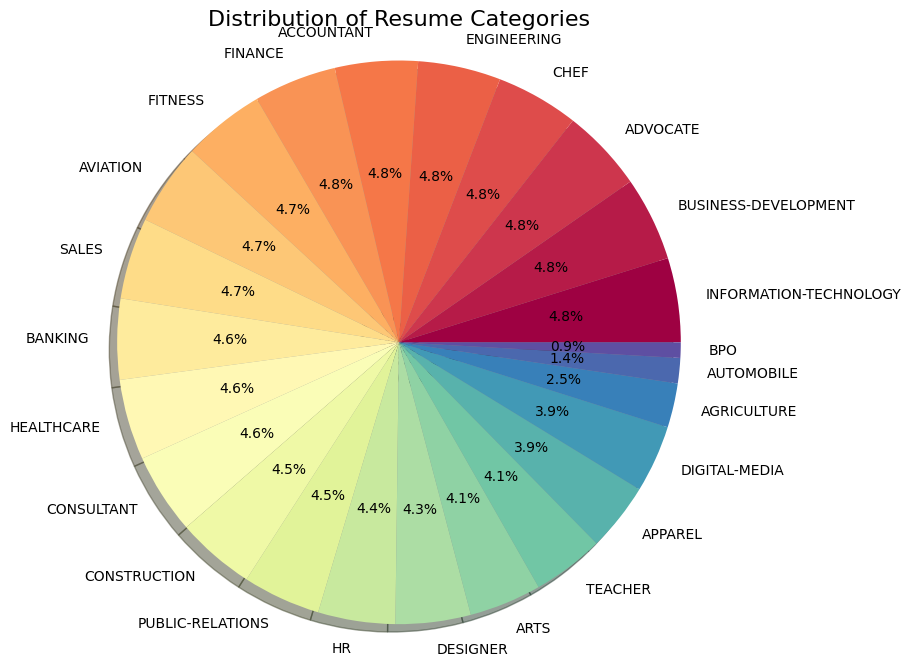

In [8]:
counts = data_df['Category'].value_counts()
labels = counts.index
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', shadow=True,
        colors=plt.cm.Spectral(np.linspace(0, 1, len(labels))))

plt.title("Distribution of Resume Categories", fontsize=16)
plt.axis('equal')
plt.show()

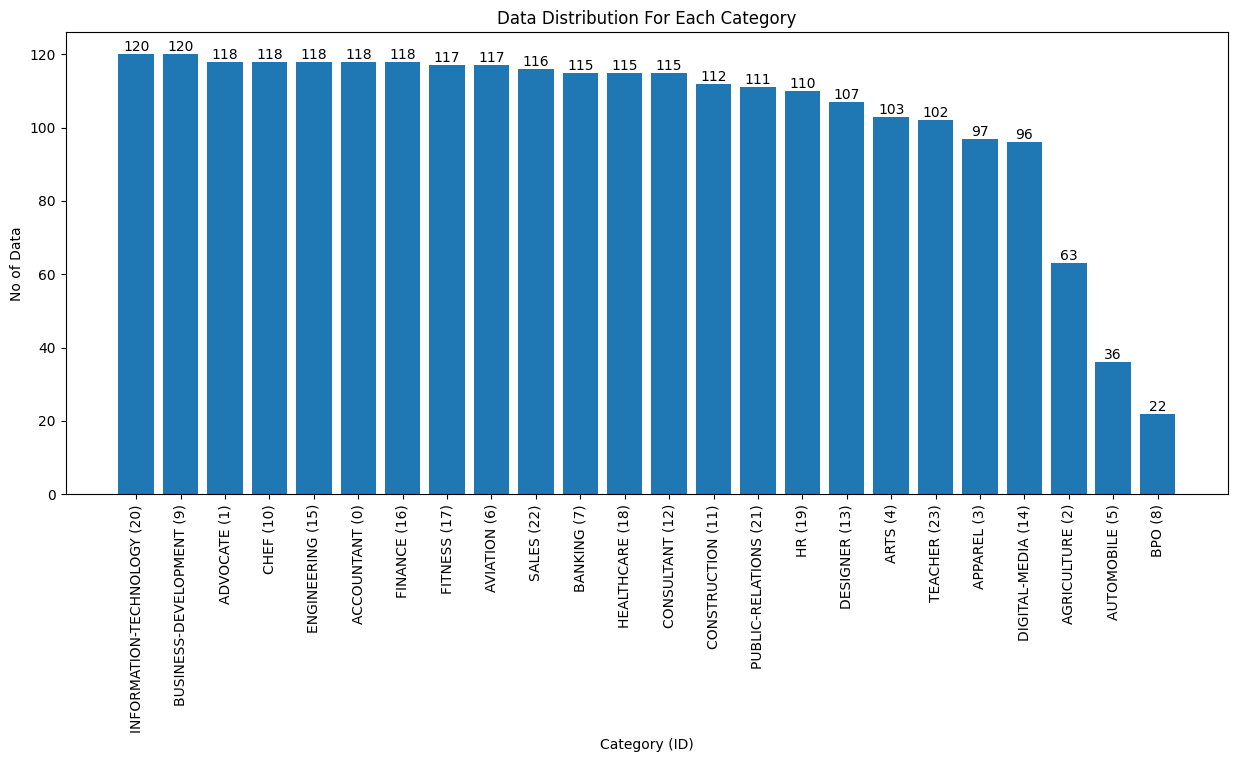

Unique numeric categories: [19 13 20 23  1  9 18 17  2  8 22 12 14  5 10 16  3 15  0 11 21  7  4  6]

Category mapping:
ACCOUNTANT --> 0
ADVOCATE --> 1
AGRICULTURE --> 2
APPAREL --> 3
ARTS --> 4
AUTOMOBILE --> 5
AVIATION --> 6
BANKING --> 7
BPO --> 8
BUSINESS-DEVELOPMENT --> 9
CHEF --> 10
CONSTRUCTION --> 11
CONSULTANT --> 12
DESIGNER --> 13
DIGITAL-MEDIA --> 14
ENGINEERING --> 15
FINANCE --> 16
FITNESS --> 17
HEALTHCARE --> 18
HR --> 19
INFORMATION-TECHNOLOGY --> 20
PUBLIC-RELATIONS --> 21
SALES --> 22
TEACHER --> 23


In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(data_df['Category'])

counts = data_df['Category'].value_counts()
ids = le.transform(counts.index)
labels = [f"{name} ({id_})" for name, id_ in zip(counts.index, ids)]
fig, ax = plt.subplots(figsize=(15, 6))
bars = ax.bar(labels, height=counts.values)

plt.xticks(rotation='vertical')
plt.title("Data Distribution For Each Category")
plt.xlabel("Category (ID)")
plt.ylabel("No of Data")
ax.bar_label(bars)
plt.show()

data_df['Category'] = le.transform(data_df['Category'])
print("Unique numeric categories:", data_df['Category'].unique())
print("\nCategory mapping:")
for i, label in enumerate(le.classes_):
    print(f"{label} --> {i}")

From the above bar-plot we can see that most of the categories have around 100+ resumes but some of the categories have a few data. So dataset is slightly imblance. So we have to be carefull during training so that the model miss these categories. Moreover we also chose model metrics carefully. We can't only use classification accuracy as model metrics as dataset is `imbalance`. We will use `F1_Score` for our model evaluation.

#### Some More EDA and Preprocessing

Lets explore contents in resumes.

In [10]:
print(f"No of rows in the dataset: {len(data_df)}")
print(f"No of unique resumes: {len(data_df['Resume_str'].unique())}")

No of rows in the dataset: 2484
No of unique resumes: 2482


So there are `some duplicate` resumes in the dataset.

In [11]:
data_df['resume_length']= data_df['Resume_str'].apply(lambda x: len(x))
data_df.head()

ID                                         Resume_str  Category  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...        19   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...        19   
2  33176873           HR DIRECTOR       Summary      Over 2...        19   
3  27018550           HR SPECIALIST       Summary    Dedica...        19   
4  17812897           HR MANAGER         Skill Highlights  ...        19   

   resume_length  
0           5442  
1           5572  
2           7720  
3           2855  
4           9172

In [12]:
display(len(data_df['resume_length'].unique()))
data_df['resume_length'].value_counts()[:10]

2033

resume_length
5196    5
5250    5
5254    4
5295    4
5533    4
5776    4
7302    4
5403    4
5980    4
5130    4
Name: count, dtype: int64

Text(0.5, 1.0, 'Resume Length Distribution')

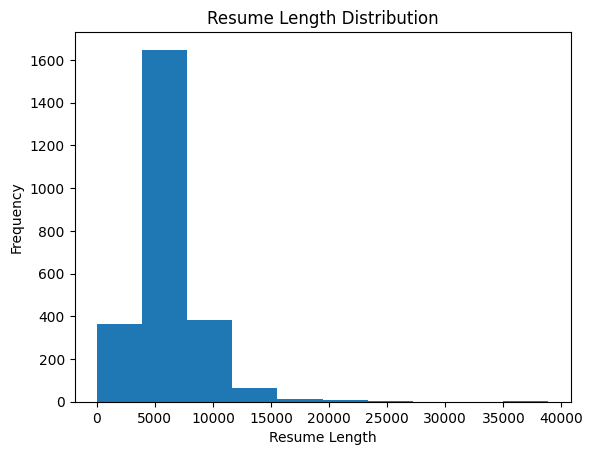

In [13]:
plt.hist(data_df['resume_length'].values)
plt.xlabel("Resume Length")
plt.ylabel("Frequency")
plt.title("Resume Length Distribution")

In [14]:
print(f"Maximum length of resumes: {max(data_df.resume_length)}")
print(f"Minimum length of resumes: {min(data_df.resume_length)}")
data_df['resume_length'].describe()

Maximum length of resumes: 38842
Minimum length of resumes: 21


count     2484.000000
mean      6295.308776
std       2769.251458
min         21.000000
25%       5160.000000
50%       5886.500000
75%       7227.250000
max      38842.000000
Name: resume_length, dtype: float64

In [15]:
data_df['no_words']= data_df['Resume_str'].apply(lambda x: len(x.split()))
data_df.no_words.describe()

count    2484.000000
mean      811.325684
std       371.006906
min         0.000000
25%       651.000000
50%       757.000000
75%       933.000000
max      5190.000000
Name: no_words, dtype: float64

Text(0.5, 1.0, 'Word count Distribution')

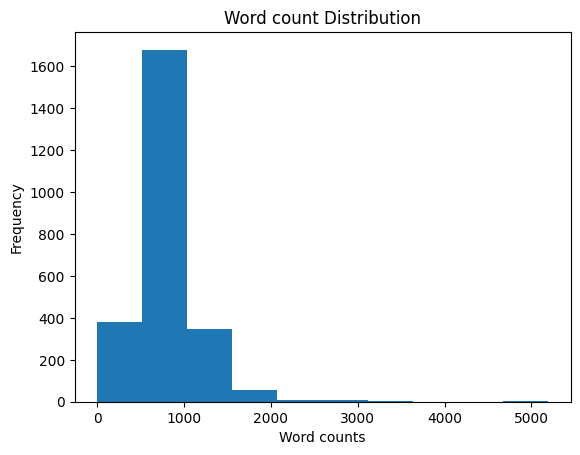

In [16]:
plt.hist(data_df['no_words'].values)
plt.xlabel("Word counts")
plt.ylabel("Frequency")
plt.title("Word count Distribution")

Most of the resume are different in size and `90%` data have `length < 8000` and `word count is < 1000`.

Lets investigate the vocabulary of the resumes.

In [17]:
def word_vocab(data):
    vocabulary = {}
    for resume in tqdm(data.values):
        for word in resume.split():
            try:
                vocabulary[word] += 1
            except:
                vocabulary[word] = 1
    sorted_vocab = sorted(vocabulary.items(), key=lambda kv: kv[1], reverse=True)
    return vocabulary, sorted_vocab
vocabulary, sorted_vocab = word_vocab(data_df['Resume_str'])

100%|██████████| 2484/2484 [00:00<00:00, 7568.63it/s]


In [18]:
sorted_vocab= sorted(vocabulary.items(), key= lambda kv:kv[1], reverse= True)

print(f"Total unique words in the vocabulary: {len(sorted_vocab)}")

sorted_vocab[:20]

Total unique words in the vocabulary: 111423


[('and', 122399),
 ('to', 53429),
 ('of', 42633),
 ('the', 35494),
 ('for', 28105),
 ('in', 27020),
 ('with', 21462),
 (',', 18910),
 ('a', 15613),
 ('State', 15278),
 ('City', 14889),
 ('Company', 11810),
 ('Name', 11602),
 ('on', 9968),
 ('as', 9950),
 ('all', 8452),
 ('－', 6890),
 ('by', 6687),
 ('customer', 5796),
 ('-', 5599)]

So, `111423` unique words in the vocabulary which is `huge` for a smaller dataset.<br>

Lets `remove stopwords` from the resumes as they are very common and see the effect in word vocabulary.

Now lets check what happens to our word vocabulary and resume lengths

> Vocabulary size reduced to `73200` from `111423` which is a huge reduction in size.

In [19]:
def char_vocab(data_df):
    chars = {}
    for resume in tqdm(data_df.Resume_str):
        for char in resume:
            try:
                chars[char] += 1
            except:
                chars[char] = 1
    return chars

chars= char_vocab(data_df)

print(f"Total Unique Characters: {len(chars)}")
display(chars)

100%|██████████| 2484/2484 [00:00<00:00, 3080.28it/s]

Total Unique Characters: 162


{' ': 2897374,
 'H': 19278,
 'R': 36235,
 'A': 69757,
 'D': 33478,
 'M': 52113,
 'I': 40931,
 'N': 32806,
 'S': 92016,
 'T': 35560,
 'O': 26609,
 '/': 25090,
 'K': 4513,
 'E': 45923,
 'G': 14036,
 'C': 94612,
 '\n': 16580,
 'u': 307338,
 'm': 322731,
 'a': 969129,
 'r': 771183,
 'y': 170076,
 'e': 1361129,
 'd': 477194,
 'i': 947913,
 'c': 473750,
 't': 960319,
 's': 764539,
 'o': 821521,
 'v': 140309,
 'n': 996602,
 'g': 267846,
 'w': 97091,
 'h': 222609,
 '1': 38322,
 '5': 11040,
 '+': 1400,
 'f': 206237,
 'x': 32749,
 'p': 312523,
 'l': 478546,
 '.': 98373,
 'b': 98050,
 '-': 31156,
 ';': 4771,
 ',': 187440,
 'F': 19195,
 'k': 67457,
 'q': 17039,
 'L': 21138,
 'W': 13935,
 'Q': 4022,
 'P': 54884,
 '(': 9270,
 ')': 9414,
 '2': 40491,
 '0': 70307,
 '3': 9959,
 '－': 6890,
 '\xa0': 8877,
 "'": 7130,
 'z': 14259,
 '9': 12925,
 'J': 7636,
 'j': 13640,
 '7': 6531,
 '&': 5524,
 '4': 8974,
 'B': 21032,
 '8': 7160,
 'U': 13624,
 'V': 8659,
 '%': 2534,
 '·': 617,
 ':': 10933,
 'Y': 2907,
 '"':

In [20]:
sorted_chars= sorted(chars.items(), key= lambda kv: kv[1], reverse= True)
display(sorted_chars[:10])

[(' ', 2897374),
 ('e', 1361129),
 ('n', 996602),
 ('a', 969129),
 ('t', 960319),
 ('i', 947913),
 ('o', 821521),
 ('r', 771183),
 ('s', 764539),
 ('l', 478546)]

In [21]:
dict(sorted_chars).keys()

dict_keys([' ', 'e', 'n', 'a', 't', 'i', 'o', 'r', 's', 'l', 'd', 'c', 'm', 'p', 'u', 'g', 'h', 'f', ',', 'y', 'v', '.', 'b', 'w', 'C', 'S', '0', 'A', 'k', 'P', 'M', 'E', 'I', '2', '1', 'R', 'T', 'D', 'N', 'x', '-', 'O', '/', 'L', 'B', 'H', 'F', 'q', '\n', 'z', 'G', 'W', 'j', 'U', '9', '5', ':', '3', ')', '(', '4', '\xa0', 'V', 'J', '6', '\t', '8', "'", '－', '7', '&', ';', 'K', 'Q', 'Y', '%', '"', '$', '*', 'X', '–', '+', '•', '_', ']', '[', '·', 'Z', '|', '\u200b', '#', '=', '?', '\xad', '●', '!', '“', '”', 'é', '➢', '~', 'ó', '◦', '>', '@', '\\', 'í', '®', '❖', '…', '�', 'á', '−', '§', 'â', '\uf0a7', '‘', '◆', 'ñ', '—', '€', 'è', '<', '™', 'ú', '’', '❏', '\u2028', '‚', '½', '}', '´', '¦', 'ô', 'Ó', '‐', '▪', 'É', '©', 'ö', '{', '\uf046', 'ü', 'Â', 'Æ', 'Ñ', '\x92', 'µ', '\uf0b7', '³', '¢', 'Á', 'À', 'ﬁ', 'Ç', 'Ò', '»', 'ï', '𝐖', 'ç', 'ê', '─'])

Total `162` characters thats huge for english vocabulary. There are some `Non-english` chacters which we will not need for our task. There are also upper-case lower-case issue. So, we will convert all the letters to lower case.

In [22]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def remove_urls(text):
    return re.sub(r'http\S+|www\.\S+', ' ', str(text))

def remove_html(text):
    return re.sub(r'<.*?>', ' ', str(text))

def remove_emojis(text):
    return emoji.replace_emoji(str(text), replace='')

def basic_cleaning(text):
    text = str(text)
    text = text.lower()
    text = remove_urls(text)
    text = remove_html(text)
    text = re.sub(r'\[.*?\]', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\b\w*\d\w*\b', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = remove_emojis(text)
    return text

def tokenize(text):
    return word_tokenize(text)

def remove_stopwords(tokens):
    return [w for w in tokens if w not in stop_words and len(w) > 1]

def apply_stemming(tokens):
    return [stemmer.stem(w) for w in tokens]

def apply_lemmatization(tokens):
    return [lemmatizer.lemmatize(w) for w in tokens]

def join_tokens(tokens):
    return ' '.join(tokens)

def preprocess_pipeline(text):
    text = basic_cleaning(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = apply_lemmatization(tokens)
    return join_tokens(tokens)

print("Preprocessing utilities completed. Applying to dataset...")
tqdm.pandas()
data_df['Resume_str'] = data_df['Resume_str'].progress_apply(preprocess_pipeline)
data_df.head()

Preprocessing utilities completed. Applying to dataset...


100%|██████████| 2484/2484 [00:19<00:00, 126.14it/s]


ID                                         Resume_str  Category  \
0  16852973  hr administrator marketing associate hr admini...        19   
1  22323967  hr specialist u hr operation summary versatile...        19   
2  33176873  hr director summary year experience recruiting...        19   
3  27018550  hr specialist summary dedicated driven dynamic...        19   
4  17812897  hr manager skill highlight hr skill hr departm...        19   

   resume_length  no_words  
0           5442       674  
1           5572       708  
2           7720      1017  
3           2855       379  
4           9172      1206

In [23]:
chars= char_vocab(data_df)

print(f"Total Unique Characters after removing non-english characters: {len(chars)}")
display(chars)

100%|██████████| 2484/2484 [00:00<00:00, 3634.69it/s]

Total Unique Characters after removing non-english characters: 27


{'h': 149511,
 'r': 749421,
 ' ': 1461864,
 'a': 852273,
 'd': 383232,
 'm': 364787,
 'i': 900905,
 'n': 851412,
 's': 573603,
 't': 847161,
 'o': 682060,
 'k': 71269,
 'e': 1314083,
 'g': 276492,
 'c': 561248,
 'u': 309525,
 'y': 178455,
 'v': 144256,
 'x': 34283,
 'p': 363789,
 'l': 478393,
 'b': 105685,
 'f': 147525,
 'q': 20869,
 'w': 77397,
 'z': 14663,
 'j': 20929}

In [24]:
sorted_chars= sorted(chars.items(), key= lambda kv: kv[1], reverse= True)
display(sorted_chars[:10])

[(' ', 1461864),
 ('e', 1314083),
 ('i', 900905),
 ('a', 852273),
 ('n', 851412),
 ('t', 847161),
 ('r', 749421),
 ('o', 682060),
 ('s', 573603),
 ('c', 561248)]

> No of unique character reduced to `27` from `162` which is reasonable as we didn't discarded some important punctuations. <br>

Lets see the character occurance distribution in bar diagram for better visualization.

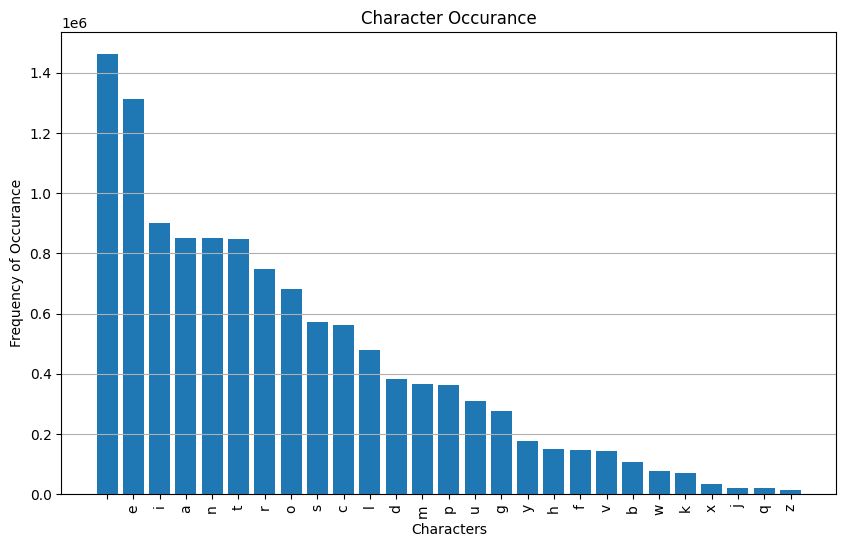

In [25]:
sorted_chars= dict(sorted_chars)
plt.figure(figsize= (10, 6))
plt.bar(x= sorted_chars.keys(), height= sorted_chars.values())
plt.title("Character Occurance")
plt.xlabel("Characters")
plt.ylabel("Frequency of Occurance")
plt.xticks(rotation= 'vertical')
plt.grid(axis= 'y')
plt.show()

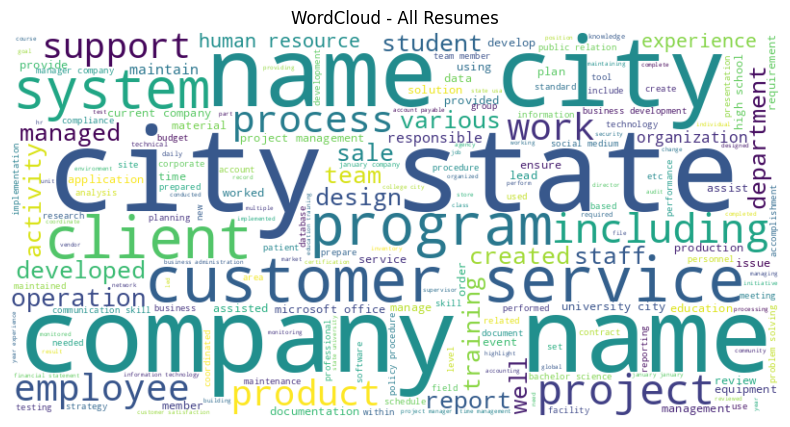

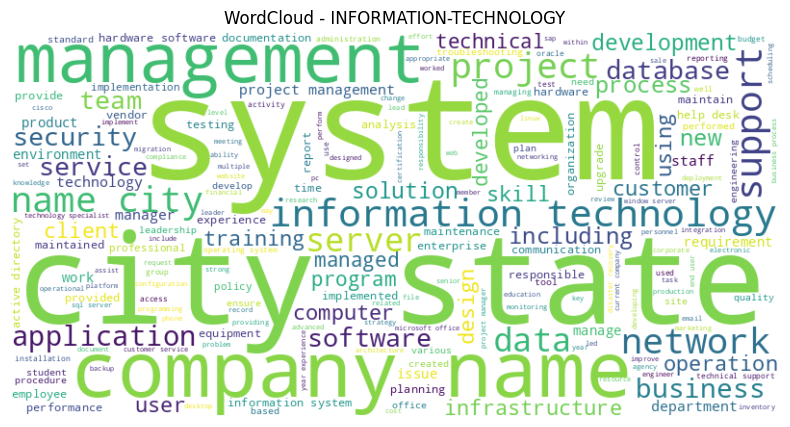

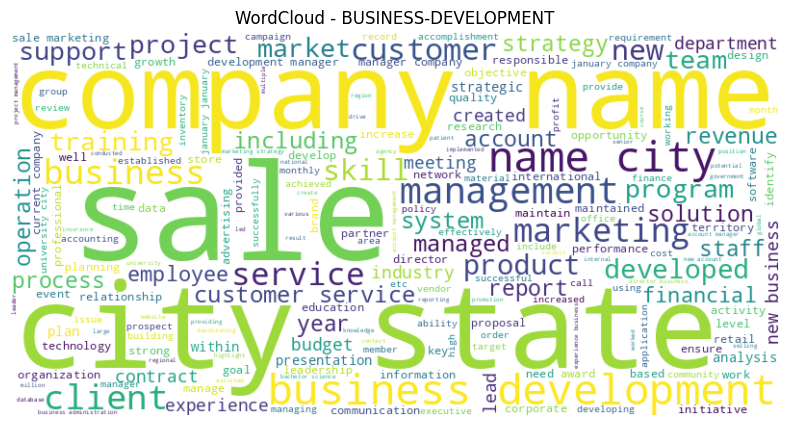

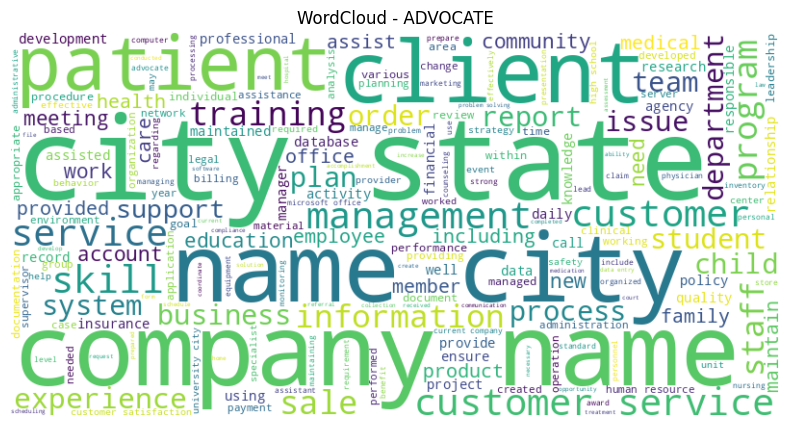

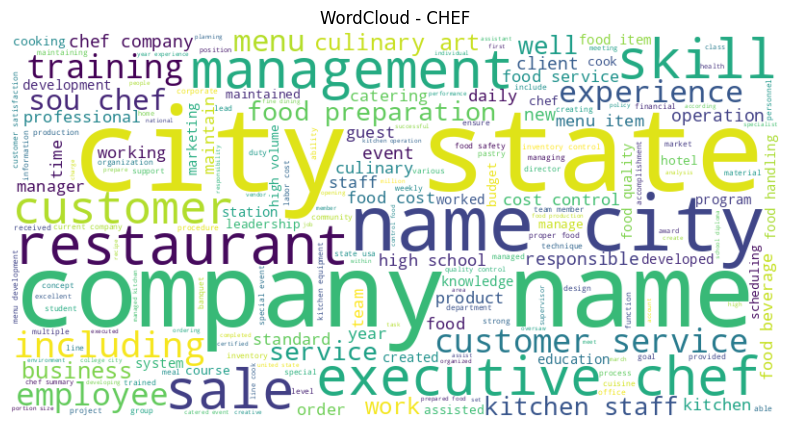

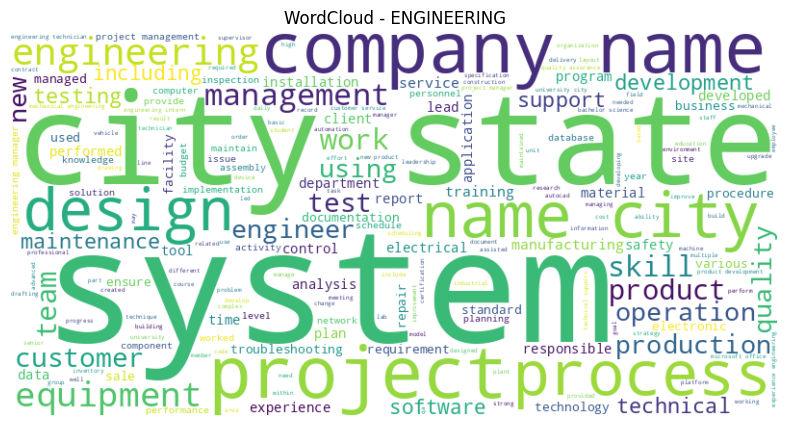

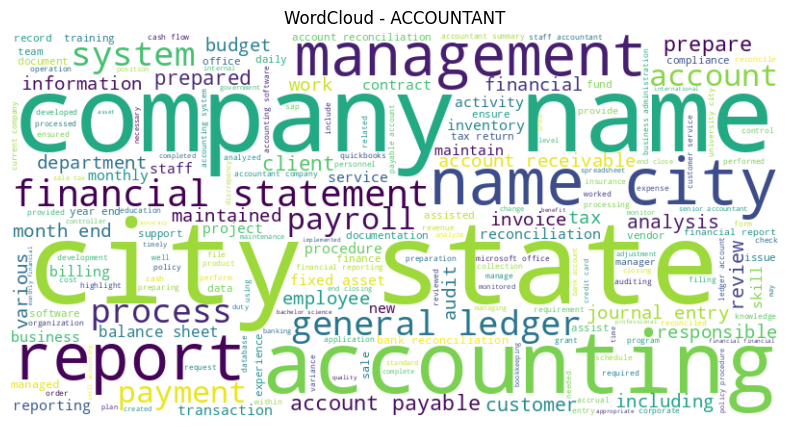

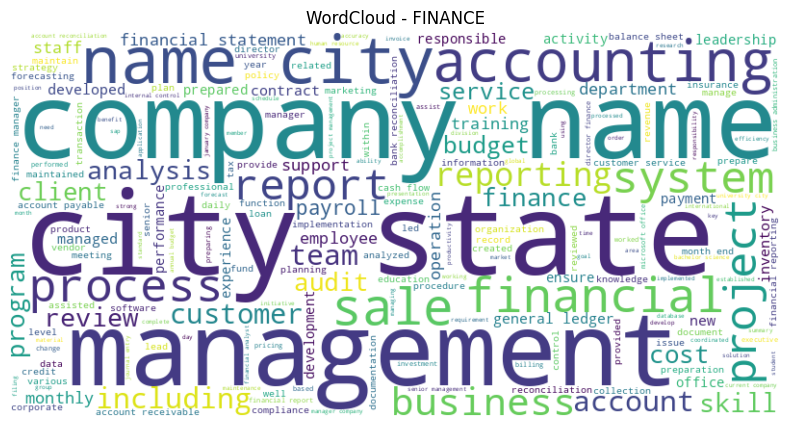

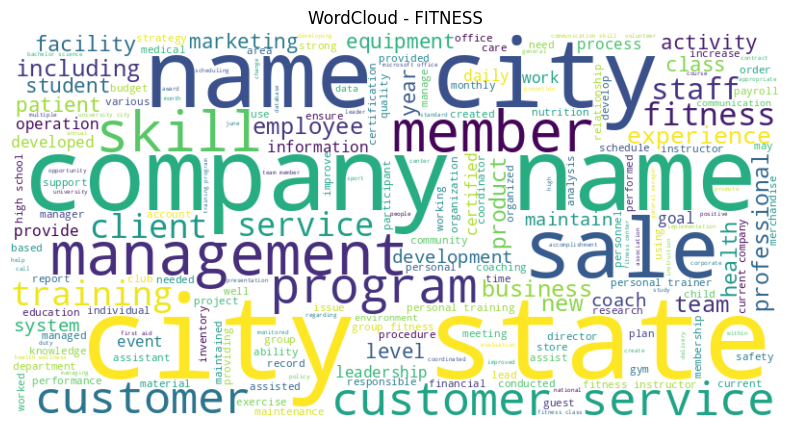

Most common words: [('state', 16772), ('company', 15720), ('city', 15117), ('management', 12171), ('name', 11705), ('customer', 11345), ('service', 9067), ('sale', 8553), ('skill', 8190), ('business', 8086), ('project', 7870), ('system', 7248), ('team', 7115), ('client', 6511), ('new', 6409), ('development', 5809), ('experience', 5780), ('training', 5754), ('manager', 5554), ('work', 5224)]


In [26]:
def show_wordcloud(text, title=None):
    if not text or len(text.strip()) == 0:
        return
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

all_text = ' '.join(data_df['Resume_str'].tolist())
show_wordcloud(all_text, title="WordCloud - All Resumes")
for cat_id in data_df['Category'].value_counts().index[:8]:
    cat_text = ' '.join(data_df[data_df['Category'] == cat_id]['Resume_str'].tolist())
    cat_name = le.inverse_transform([cat_id])[0]
    show_wordcloud(cat_text, title=f"WordCloud - {cat_name}")

data_df['tokens'] = data_df['Resume_str'].apply(lambda x: x.split())
all_tokens = [token for sublist in data_df['tokens'] for token in sublist]
word_freq = Counter(all_tokens)
print("Most common words:", word_freq.most_common(20))

          sentiment
Category           
22         0.178475
3          0.156761
10         0.156434
17         0.149780
23         0.144436
5          0.143267
4          0.142950
13         0.142141
1          0.140983
11         0.138093
18         0.134356
19         0.133135
21         0.132396
8          0.130193
9          0.127888
2          0.127813
14         0.126862
12         0.116973
7          0.115827
15         0.115700
6          0.115043
16         0.112122
20         0.111795
0          0.102434


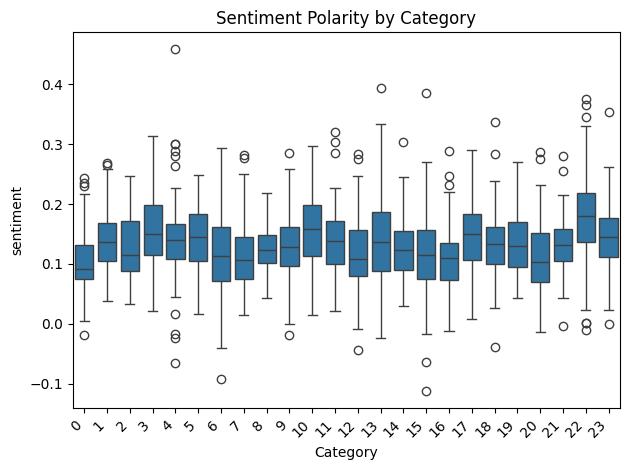

In [27]:
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

data_df['sentiment'] = data_df['Resume_str'].apply(get_sentiment)

print(data_df[['Category', 'sentiment']].groupby('Category').mean().sort_values('sentiment', ascending=False))

sns.boxplot(data=data_df, x='Category', y='sentiment')
plt.xticks(rotation=45, ha='right')
plt.title('Sentiment Polarity by Category')
plt.tight_layout()
plt.show()

In [28]:
tfidf = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 2),
    max_features=20000,
    min_df=2,
    max_df=0.9
)
tfidf.fit(data_df['Resume_str'])
X = tfidf.transform(data_df['Resume_str'])
print("TF-IDF matrix shape:", X.shape)

TF-IDF matrix shape: (2484, 20000)


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    data_df['Category'],
    test_size=0.2,
    random_state=42
)
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (1987, 20000)
Testing data shape: (497, 20000)


### Model Training: Naive Bayes Classifier
We will start with Multinomial Naive Bayes, a popular baseline for text classification tasks.

Tuning Naive Bayes hyperparameters...
Best Alpha found: 0.01
Best Cross-Validation Accuracy: 57.98%

Tuned Model Accuracy on Test Set: 57.55%

Classification Report (Tuned):
                        precision    recall  f1-score   support

            ACCOUNTANT       0.79      0.90      0.84        29
              ADVOCATE       0.45      0.47      0.46        30
           AGRICULTURE       0.17      0.12      0.14         8
               APPAREL       0.53      0.40      0.46        20
                  ARTS       0.30      0.17      0.21        18
            AUTOMOBILE       0.50      0.17      0.25         6
              AVIATION       0.59      0.76      0.67        21
               BANKING       0.71      0.65      0.68        23
                   BPO       0.00      0.00      0.00         2
  BUSINESS-DEVELOPMENT       0.65      0.63      0.64        27
                  CHEF       0.88      0.62      0.73        24
          CONSTRUCTION       0.82      0.68      0.74    

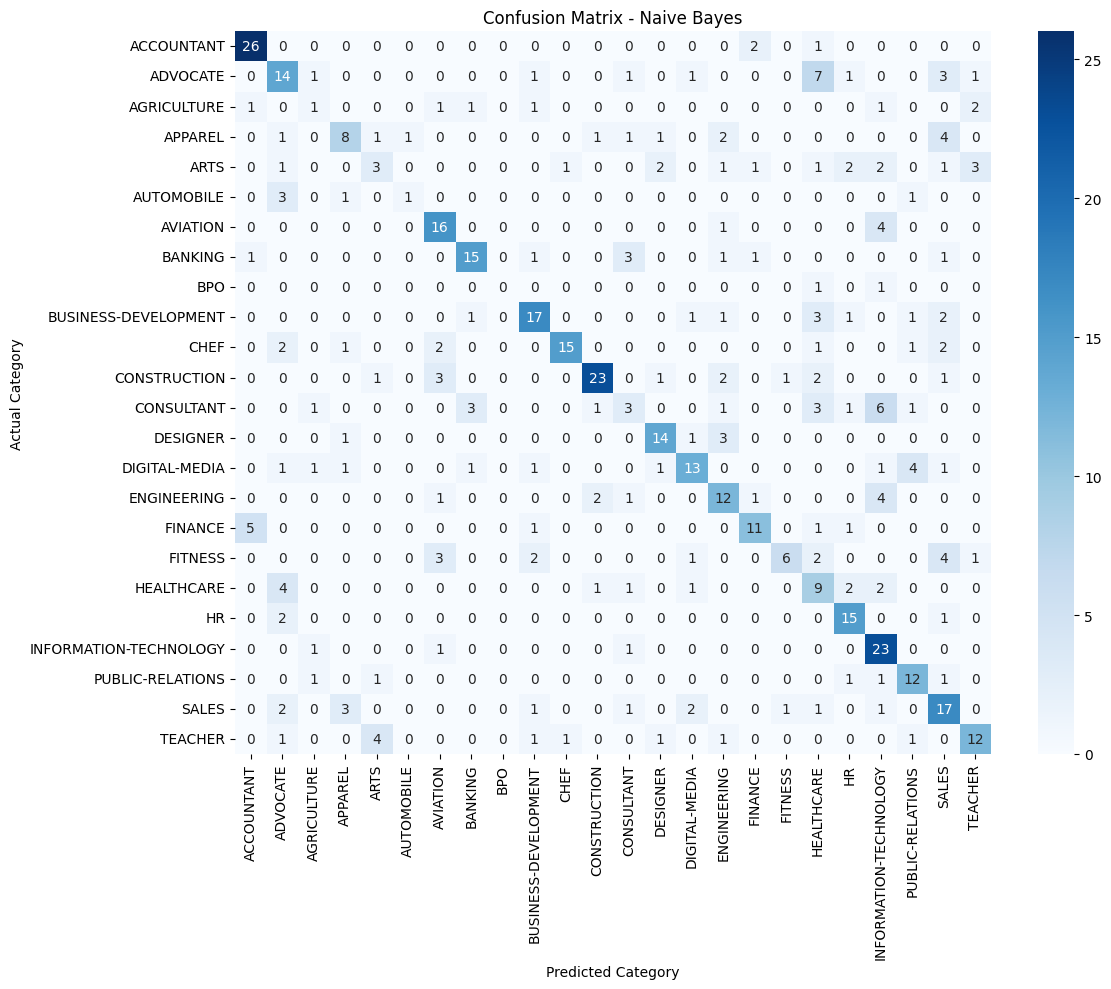

In [30]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0]}
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)

print("Tuning Naive Bayes hyperparameters...")
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
print(f"Best Alpha found: {best_alpha}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.2%}")
best_nb_model = grid_search.best_estimator_
y_pred_tuned = best_nb_model.predict(X_test)

accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"\nTuned Model Accuracy on Test Set: {accuracy_tuned:.2%}")

print("\nClassification Report (Tuned):")
print(classification_report(y_test, y_pred_tuned, target_names=categories, zero_division=0))
plt.figure(figsize=(12, 10))
cm_nb = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.title('Confusion Matrix - Naive Bayes')
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Multiclass Precision-Recall Curves for Naive Bayes Model

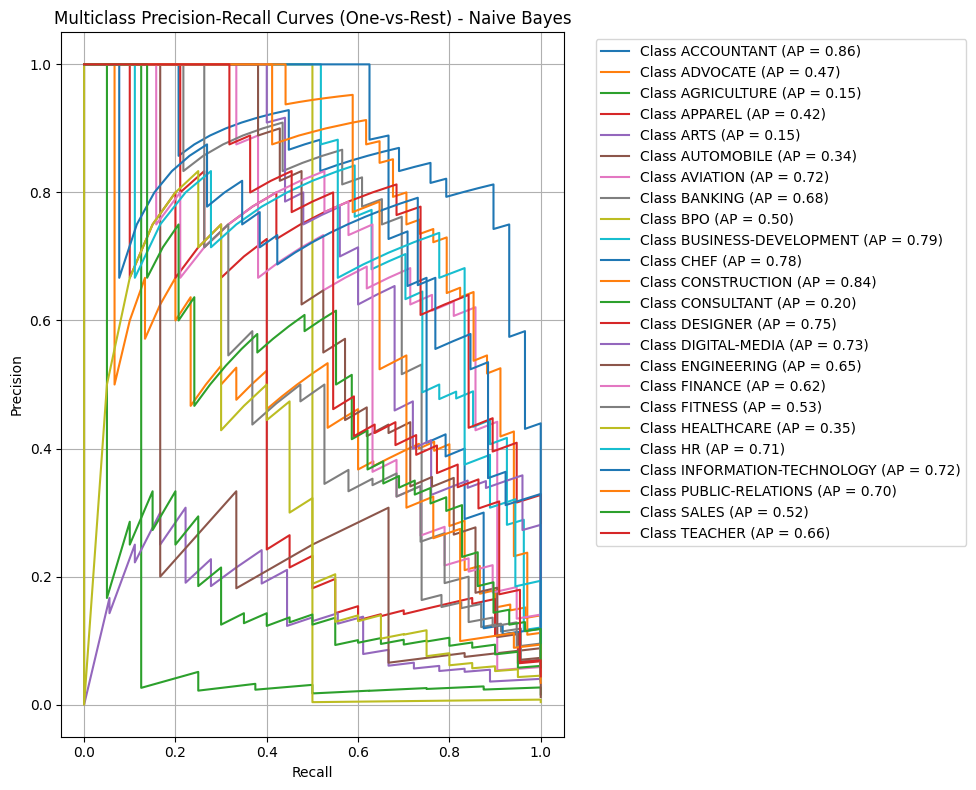

Average Precision (AP) for each class (Naive Bayes):
  ACCOUNTANT: 0.865
  ADVOCATE: 0.474
  AGRICULTURE: 0.152
  APPAREL: 0.420
  ARTS: 0.152
  AUTOMOBILE: 0.343
  AVIATION: 0.723
  BANKING: 0.683
  BPO: 0.504
  BUSINESS-DEVELOPMENT: 0.788
  CHEF: 0.782
  CONSTRUCTION: 0.840
  CONSULTANT: 0.200
  DESIGNER: 0.753
  DIGITAL-MEDIA: 0.727
  ENGINEERING: 0.650
  FINANCE: 0.621
  FITNESS: 0.529
  HEALTHCARE: 0.354
  HR: 0.711
  INFORMATION-TECHNOLOGY: 0.716
  PUBLIC-RELATIONS: 0.702
  SALES: 0.520
  TEACHER: 0.664


In [31]:
class_probabilities_nb = best_nb_model.predict_proba(X_test)
plt.figure(figsize=(10, 8))
avg_precisions_nb = {}
for i, class_name in enumerate(le.classes_):
    y_true_binary = (y_test == i).astype(int)
    y_score_class = class_probabilities_nb[:, i]
    precision, recall, _ = precision_recall_curve(y_true_binary, y_score_class)
    ap = average_precision_score(y_true_binary, y_score_class)
    avg_precisions_nb[class_name] = ap
    plt.plot(recall, precision, label=f'Class {class_name} (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curves (One-vs-Rest) - Naive Bayes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Average Precision (AP) for each class (Naive Bayes):")
for class_name, ap_score in avg_precisions_nb.items():
    print(f"  {class_name}: {ap_score:.3f}")

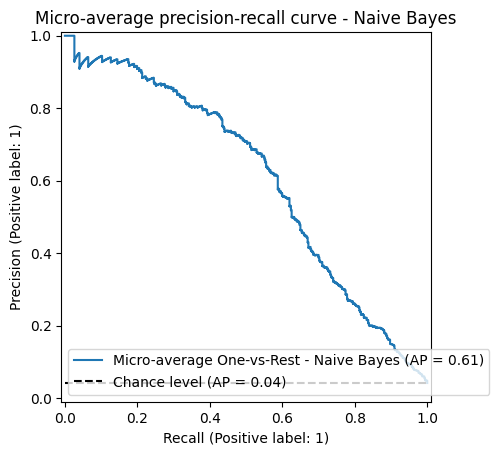

Micro-average Average Precision (Naive Bayes): 0.606
Macro-average Average Precision (Naive Bayes): 0.578


In [32]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import PrecisionRecallDisplay
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
class_probabilities_nb = best_nb_model.predict_proba(X_test)
display = PrecisionRecallDisplay.from_predictions(
    y_test_binarized.ravel(),
    class_probabilities_nb.ravel(),
    name="Micro-average One-vs-Rest - Naive Bayes",
    plot_chance_level=True
)
_ = display.ax_.set_title("Micro-average precision-recall curve - Naive Bayes")
plt.show()

print(f"Micro-average Average Precision (Naive Bayes): {average_precision_score(y_test_binarized, class_probabilities_nb, average='micro'):.3f}")
print(f"Macro-average Average Precision (Naive Bayes): {np.mean(list(avg_precisions_nb.values())):.3f}")

Why Naive Bayes might not be the best fit?
While we improved accuracy with hyperparameter tuning, Naive Bayes often hits a performance ceiling on tasks like Resume Classification because:

Feature Independence Assumption: Naive Bayes assumes that the presence of a word (e.g., "Python") is completely unrelated to the presence of another (e.g., "Developer"). In natural language, word order and combinations carry significant meaning (e.g., "Project Manager" vs. "Project Assistant"), which Naive Bayes ignores.
Frequency vs. Semantics: It relies solely on word counts. It doesn't understand that "programmer" and "developer" are synonyms unless they appear frequently in the same category.
Imbalanced Data: While we used a stratified split, Naive Bayes can still favor majority classes if the unique features for minority classes are sparse.
Better Alternatives:

Support Vector Machines (SVM): excellent at finding the best boundary in high-dimensional spaces (like TF-IDF data).
Random Forest / XGBoost: Can capture non-linear relationships between words.
Transformers (BERT/RoBERTa): The state-of-the-art approach that understands context and semantics.

Training SVM Model...

SVM Model Accuracy: 71.03%

Classification Report (SVM):
                        precision    recall  f1-score   support

            ACCOUNTANT       0.84      0.90      0.87        29
              ADVOCATE       0.64      0.70      0.67        30
           AGRICULTURE       0.40      0.25      0.31         8
               APPAREL       0.58      0.55      0.56        20
                  ARTS       0.50      0.28      0.36        18
            AUTOMOBILE       0.40      0.33      0.36         6
              AVIATION       0.75      0.86      0.80        21
               BANKING       0.81      0.74      0.77        23
                   BPO       0.25      0.50      0.33         2
  BUSINESS-DEVELOPMENT       0.91      0.74      0.82        27
                  CHEF       0.89      0.71      0.79        24
          CONSTRUCTION       0.85      0.82      0.84        34
            CONSULTANT       0.64      0.35      0.45        20
              DESIGNER 

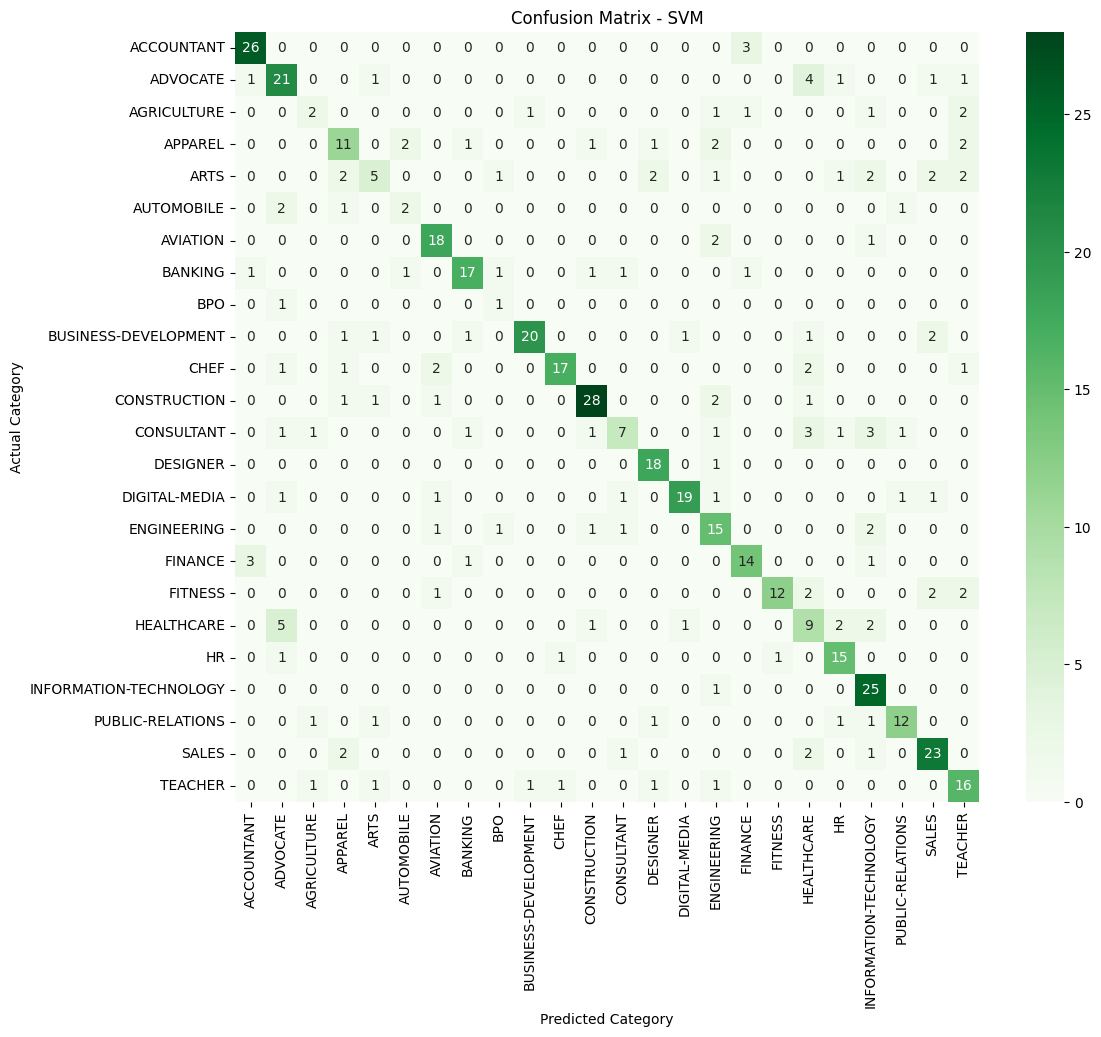

In [33]:
svm_model = LinearSVC(class_weight='balanced', random_state=42)
print("Training SVM Model...")
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"\nSVM Model Accuracy: {accuracy_svm:.2%}")

print("\nClassification Report (SVM):")
print(classification_report(y_test, y_pred_svm, target_names=categories, zero_division=0))
plt.figure(figsize=(12, 10))
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens',
            xticklabels=categories,
            yticklabels=categories)
plt.title('Confusion Matrix - SVM')
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.xticks(rotation=90)
plt.show()

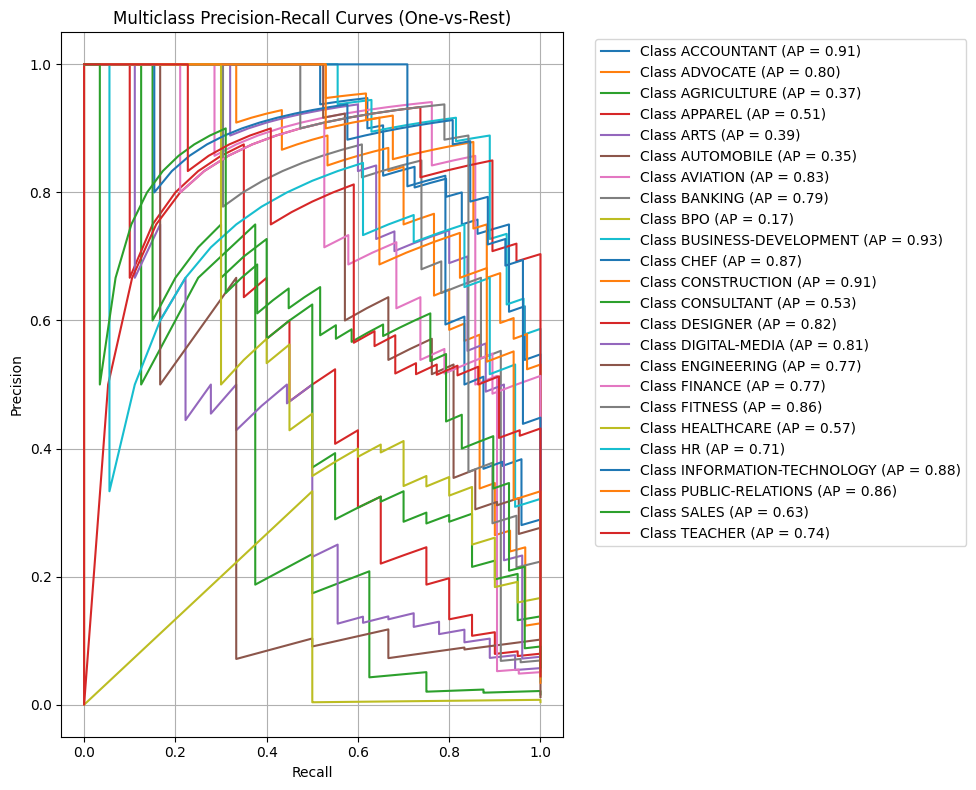

Average Precision (AP) for each class:
  ACCOUNTANT: 0.906
  ADVOCATE: 0.801
  AGRICULTURE: 0.370
  APPAREL: 0.513
  ARTS: 0.391
  AUTOMOBILE: 0.346
  AVIATION: 0.832
  BANKING: 0.788
  BPO: 0.170
  BUSINESS-DEVELOPMENT: 0.932
  CHEF: 0.867
  CONSTRUCTION: 0.913
  CONSULTANT: 0.530
  DESIGNER: 0.823
  DIGITAL-MEDIA: 0.812
  ENGINEERING: 0.768
  FINANCE: 0.774
  FITNESS: 0.860
  HEALTHCARE: 0.570
  HR: 0.713
  INFORMATION-TECHNOLOGY: 0.879
  PUBLIC-RELATIONS: 0.856
  SALES: 0.625
  TEACHER: 0.743


In [34]:
decision_scores = svm_model.decision_function(X_test)
plt.figure(figsize=(10, 8))
avg_precisions = {}
for i, class_name in enumerate(le.classes_):
    y_true_binary = (y_test == i).astype(int)
    y_score_class = decision_scores[:, i]
    precision, recall, _ = precision_recall_curve(y_true_binary, y_score_class)
    ap = average_precision_score(y_true_binary, y_score_class)
    avg_precisions[class_name] = ap
    plt.plot(recall, precision, label=f'Class {class_name} (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curves (One-vs-Rest)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Average Precision (AP) for each class:")
for class_name, ap_score in avg_precisions.items():
    print(f"  {class_name}: {ap_score:.3f}")

From these individual precision-recall curves, you can analyze the trade-off between precision and recall for each specific resume category. A higher curve and a higher Average Precision (AP) indicate better performance for that class.

You can also compute **micro-average** and **macro-average** precision-recall curves, which provide overall performance summaries across all classes:

*   **Micro-average**: Aggregates the contributions of all classes to compute the average metric. It's suitable for imbalanced datasets and is sensitive to the frequency of each class.
*   **Macro-average**: Computes the metric independently for each class and then takes the average (treating all classes equally). It's more sensitive to the performance on minority classes.

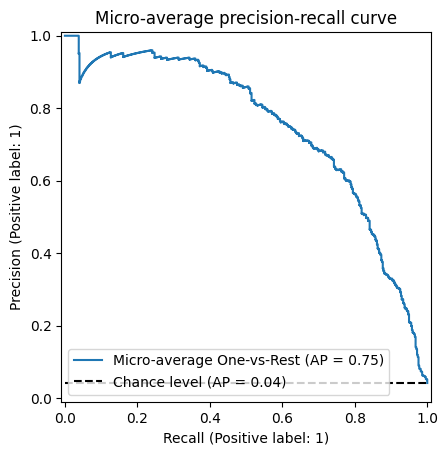

Micro-average Average Precision: 0.747
Macro-average Average Precision: 0.699


In [35]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import PrecisionRecallDisplay
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
decision_scores = svm_model.decision_function(X_test)
display = PrecisionRecallDisplay.from_predictions(
    y_test_binarized.ravel(),
    decision_scores.ravel(),
    name="Micro-average One-vs-Rest",
    plot_chance_level=True
)
_ = display.ax_.set_title("Micro-average precision-recall curve")
plt.show()
print(f"Micro-average Average Precision: {average_precision_score(y_test_binarized, decision_scores, average='micro'):.3f}")
print(f"Macro-average Average Precision: {np.mean(list(avg_precisions.values())):.3f}")

In [36]:
import pickle
pickle.dump(tfidf, open('tfidf.pkl', 'wb'))
pickle.dump(svm_model, open('clf.pkl', 'wb'))
pickle.dump(le, open("encoder.pkl", 'wb'))
print("All components saved successfully!")

All components saved successfully!


In [37]:
def predict_resume_category(input_resume):
    cleaned_text = basic_cleaning(input_resume)
    vectorized_text = tfidf.transform([cleaned_text])
    vectorized_text = vectorized_text.toarray()
    predicted_label = svm_model.predict(vectorized_text)
    predicted_category = le.inverse_transform(predicted_label)
    return predicted_category[0]

In [38]:
sample_resume = """Experienced software engineer skilled in Python, machine learning, and data analysis. Worked on various AI projects..."""
print("Predicted Category:", predict_resume_category(sample_resume))

Predicted Category: ENGINEERING


In [39]:
sales_resume = """
Highly motivated Sales Associate with 5+ years of experience in retail and B2B sales.
Proven track record of exceeding sales quotas and driving revenue growth.
Skilled in lead generation, negotiation, and CRM software (Salesforce).
Strong communication and interpersonal skills.
"""
print(f"Predicted Category: {predict_resume_category(sales_resume)}")

Predicted Category: BUSINESS-DEVELOPMENT


In [40]:
myresume = """
John Doe is an experienced Network Security Engineer with over 7 years of expertise in designing, implementing, and managing network security infrastructures. Specializing in safeguarding critical network systems, John has worked with various organizations to protect against cyber threats, data breaches, and unauthorized access. He is proficient in deploying firewalls, intrusion detection systems (IDS), VPNs, and network monitoring tools to ensure the integrity and security of networks.

John holds a degree in Computer Science and certifications in several cybersecurity domains, including Certified Information Systems Security Professional (CISSP), Certified Ethical Hacker (CEH), and Cisco Certified Network Associate (CCNA). He has extensive experience in troubleshooting and resolving network vulnerabilities, and has played a key role in conducting security audits and risk assessments.

Key Skills:
- Network Security Architecture
- Firewall Management and Configuration
- Intrusion Detection and Prevention Systems (IDS/IPS)
- Virtual Private Networks (VPNs)
- Security Audits and Risk Assessments
- Cybersecurity Incident Response
- Network Monitoring and Traffic Analysis
- Vulnerability Assessment and Penetration Testing
- Data Encryption and Secure Communications

Certifications:
- CISSP (Certified Information Systems Security Professional)
- CEH (Certified Ethical Hacker)
- CCNA (Cisco Certified Network Associate)
- CompTIA Security+

Education:
BSc in Computer Science, XYZ University, 2012-2016

Professional Experience:
- Network Security Engineer at ABC Corp (2016-Present)
- IT Security Specialist at DEF Solutions (2014-2016)

Languages:
- English (Fluent)
- French (Intermediate)
"""

predict_resume_category(myresume)


'INFORMATION-TECHNOLOGY'

XGBoost Accuracy: 0.799, F1-macro: 0.760

Classification Report (XGBoost):
                        precision    recall  f1-score   support

            ACCOUNTANT       0.93      0.97      0.95        29
              ADVOCATE       0.96      0.90      0.93        30
           AGRICULTURE       0.83      0.62      0.71         8
               APPAREL       0.69      0.55      0.61        20
                  ARTS       0.53      0.50      0.51        18
            AUTOMOBILE       0.20      0.17      0.18         6
              AVIATION       0.79      0.90      0.84        21
               BANKING       0.64      0.70      0.67        23
                   BPO       1.00      0.50      0.67         2
  BUSINESS-DEVELOPMENT       0.82      0.85      0.84        27
                  CHEF       0.95      0.79      0.86        24
          CONSTRUCTION       0.87      0.97      0.92        34
            CONSULTANT       0.76      0.65      0.70        20
              DESIGNER      

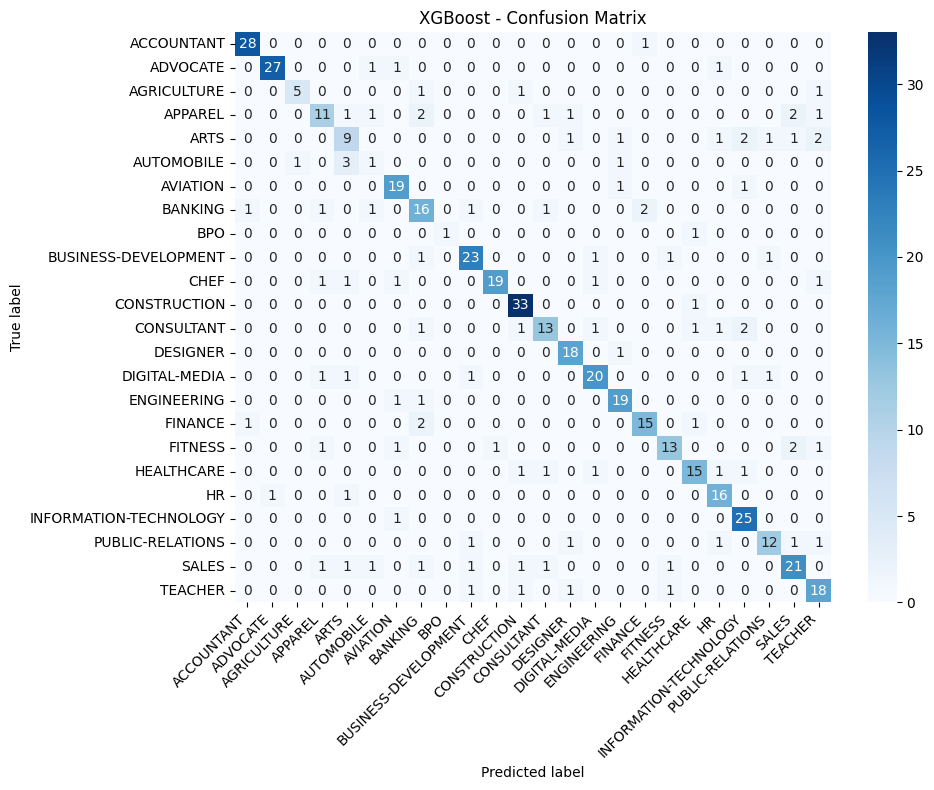

In [41]:
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weight_dict = {cls: w for cls, w in zip(classes, class_weights)}

sample_weight = np.array([class_weight_dict[c] for c in y_train])

xgb_clf = XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    learning_rate=0.15,
    max_depth=8,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    tree_method='hist',
    random_state=42,
    eval_metric='mlogloss'
)

xgb_clf.fit(X_train, y_train, sample_weight=sample_weight)

y_pred_xgb = xgb_clf.predict(X_test)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb, average='macro')

print(f"XGBoost Accuracy: {acc_xgb:.3f}, F1-macro: {f1_xgb:.3f}")
print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_xgb,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title("XGBoost - Confusion Matrix")
plt.tight_layout()
plt.show()

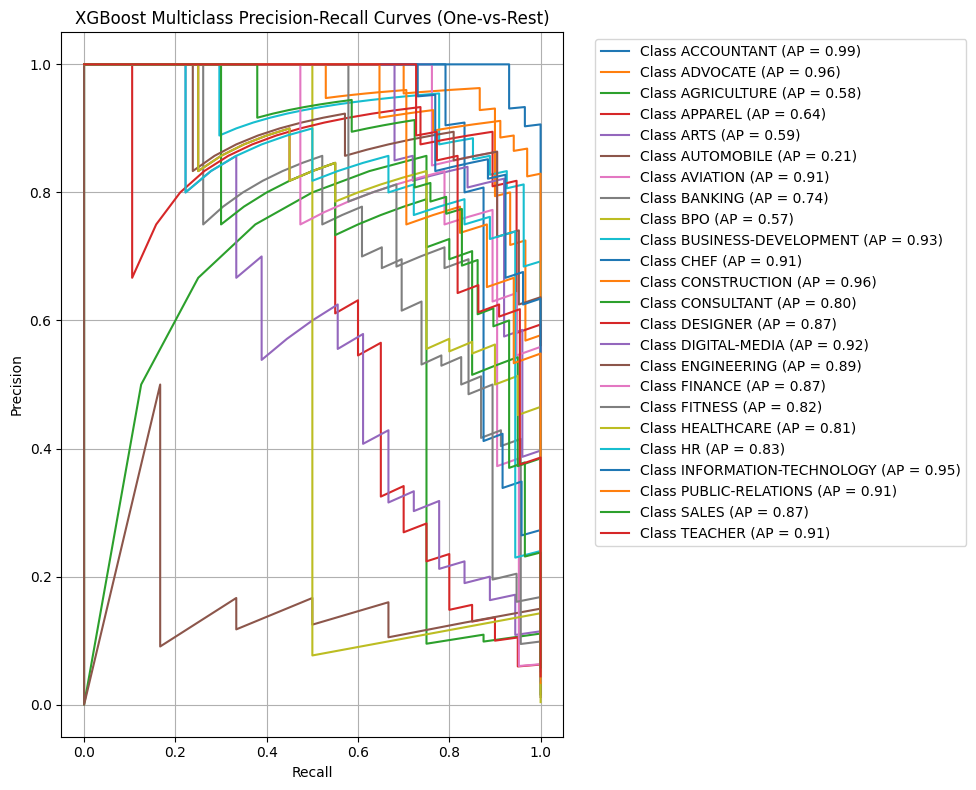

Average Precision (AP) for each class:
  ACCOUNTANT: 0.994
  ADVOCATE: 0.961
  AGRICULTURE: 0.578
  APPAREL: 0.636
  ARTS: 0.586
  AUTOMOBILE: 0.212
  AVIATION: 0.906
  BANKING: 0.742
  BPO: 0.571
  BUSINESS-DEVELOPMENT: 0.930
  CHEF: 0.907
  CONSTRUCTION: 0.962
  CONSULTANT: 0.802
  DESIGNER: 0.873
  DIGITAL-MEDIA: 0.919
  ENGINEERING: 0.894
  FINANCE: 0.872
  FITNESS: 0.821
  HEALTHCARE: 0.807
  HR: 0.834
  INFORMATION-TECHNOLOGY: 0.947
  PUBLIC-RELATIONS: 0.908
  SALES: 0.867
  TEACHER: 0.911


In [42]:
y_score = xgb_clf.predict_proba(X_test)

plt.figure(figsize=(10, 8))
avg_precisions = {}

for i, class_name in enumerate(le.classes_):
    y_true_binary = (y_test == i).astype(int)
    y_score_class = y_score[:, i]

    precision, recall, _ = precision_recall_curve(y_true_binary, y_score_class)
    ap = average_precision_score(y_true_binary, y_score_class)
    avg_precisions[class_name] = ap

    plt.plot(recall, precision, label=f'Class {class_name} (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBoost Multiclass Precision-Recall Curves (One-vs-Rest)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Average Precision (AP) for each class:")
for class_name, ap_score in avg_precisions.items():
    print(f"  {class_name}: {ap_score:.3f}")

XGBoost micro-average AP: 0.869


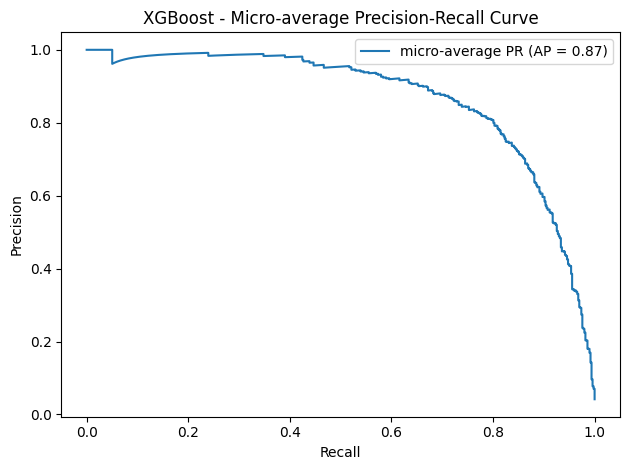

XGBoost macro-average AP: 0.810


In [43]:
y_score_xgb = xgb_clf.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
n_classes = y_test_bin.shape[1]
precision = {}
recall = {}
avg_precision = {}
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_bin.ravel(), y_score_xgb.ravel()
)
avg_precision["micro"] = average_precision_score(
    y_test_bin, y_score_xgb, average="micro"
)
print(f"XGBoost micro-average AP: {avg_precision['micro']:.3f}")

plt.plot(recall["micro"], precision["micro"],
         label=f"micro-average PR (AP = {avg_precision['micro']:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("XGBoost - Micro-average Precision-Recall Curve")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

avg_precisions_per_class = []
for i in range(n_classes):
    ap_i = average_precision_score(y_test_bin[:, i], y_score_xgb[:, i])
    avg_precisions_per_class.append(ap_i)
macro_avg_ap_xgb = np.mean(avg_precisions_per_class)
print(f"XGBoost macro-average AP: {macro_avg_ap_xgb:.3f}")

Map:   0%|          | 0/1987 [00:00<?, ? examples/s]

Map:   0%|          | 0/497 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Transformer evaluation: {'eval_loss': 0.5218703746795654, 'eval_accuracy': 0.8812877263581489, 'eval_f1_macro': 0.8152007918034015, 'eval_runtime': 1.0189, 'eval_samples_per_second': 251.258, 'eval_steps_per_second': 7.852, 'epoch': 10.0}


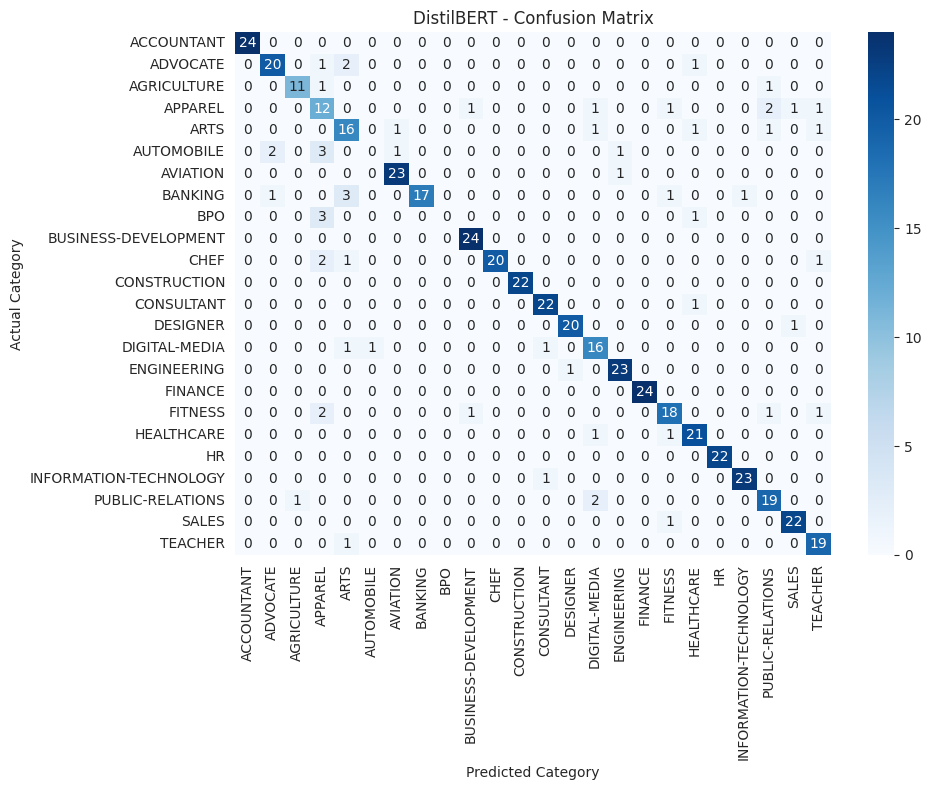


DistilBERT Classification Report:
                        precision    recall  f1-score   support

            ACCOUNTANT       1.00      1.00      1.00        24
              ADVOCATE       0.87      0.83      0.85        24
           AGRICULTURE       0.92      0.85      0.88        13
               APPAREL       0.50      0.63      0.56        19
                  ARTS       0.67      0.76      0.71        21
            AUTOMOBILE       0.00      0.00      0.00         7
              AVIATION       0.92      0.96      0.94        24
               BANKING       1.00      0.74      0.85        23
                   BPO       0.00      0.00      0.00         4
  BUSINESS-DEVELOPMENT       0.92      1.00      0.96        24
                  CHEF       1.00      0.83      0.91        24
          CONSTRUCTION       1.00      1.00      1.00        22
            CONSULTANT       0.92      0.96      0.94        23
              DESIGNER       0.95      0.95      0.95        21
    

In [50]:
model_name = "distilbert-base-uncased"
tokenizer_hf = AutoTokenizer.from_pretrained(model_name)
train_text_data, test_text_data, train_labels, test_labels = train_test_split(
    data_df['Resume_str'],
    data_df['Category'],
    test_size=0.2,
    random_state=42,
    stratify=data_df['Category']
)
train_df = pd.DataFrame({"text": train_text_data.tolist(), "label": train_labels.tolist()})
test_df = pd.DataFrame({"text": test_text_data.tolist(), "label": test_labels.tolist()})
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

def tokenize_batch(batch):
    return tokenizer_hf(
        batch["text"],
        truncation=True,
        padding=True,
        max_length=512
    )

train_dataset = train_dataset.map(tokenize_batch, batched=True)
test_dataset = test_dataset.map(tokenize_batch, batched=True)
drop_cols_train = [col for col in ["text", "__index_level_0__"] if col in train_dataset.column_names]
drop_cols_test = [col for col in ["text", "__index_level_0__"] if col in test_dataset.column_names]
train_dataset = train_dataset.remove_columns(drop_cols_train)
test_dataset = test_dataset.remove_columns(drop_cols_test)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer_hf)
id2label = {i: category_name for i, category_name in enumerate(categories)}
label2id = {category_name: i for i, category_name in enumerate(categories)}

model_hf = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="./distilbert-resume-classifier",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    report_to="none",
    optim="adamw_torch"
    )

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    return {"accuracy": acc, "f1_macro": f1}

trainer = Trainer(
    model=model_hf,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer_hf,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

trainer.train()

eval_results = trainer.evaluate()
print("Transformer evaluation:", eval_results)

predictions = trainer.predict(test_dataset)
y_pred_hf = np.argmax(predictions.predictions, axis=1)
cm_hf = confusion_matrix(test_labels, y_pred_hf)

def plot_confusion_matrix(cm, labels, title='Confusion Matrix'):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels,
                yticklabels=labels)
    plt.title(title)
    plt.ylabel('Actual Category')
    plt.xlabel('Predicted Category')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm_hf, categories, title="DistilBERT - Confusion Matrix")
print("\nDistilBERT Classification Report:")
print(classification_report(test_labels, y_pred_hf, target_names=categories))

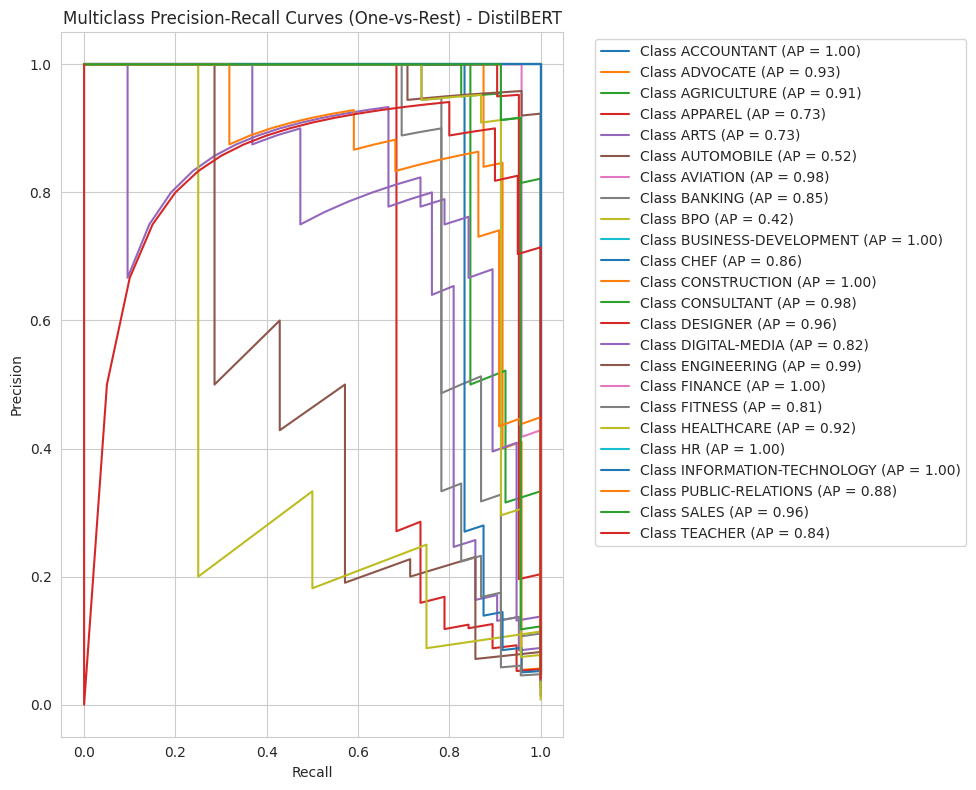


Average Precision (AP) for each class (DistilBERT):
  ACCOUNTANT: 1.000
  ADVOCATE: 0.930
  AGRICULTURE: 0.912
  APPAREL: 0.729
  ARTS: 0.734
  AUTOMOBILE: 0.520
  AVIATION: 0.976
  BANKING: 0.849
  BPO: 0.424
  BUSINESS-DEVELOPMENT: 1.000
  CHEF: 0.857
  CONSTRUCTION: 1.000
  CONSULTANT: 0.985
  DESIGNER: 0.960
  DIGITAL-MEDIA: 0.819
  ENGINEERING: 0.985
  FINANCE: 1.000
  FITNESS: 0.811
  HEALTHCARE: 0.919
  HR: 1.000
  INFORMATION-TECHNOLOGY: 1.000
  PUBLIC-RELATIONS: 0.876
  SALES: 0.958
  TEACHER: 0.845


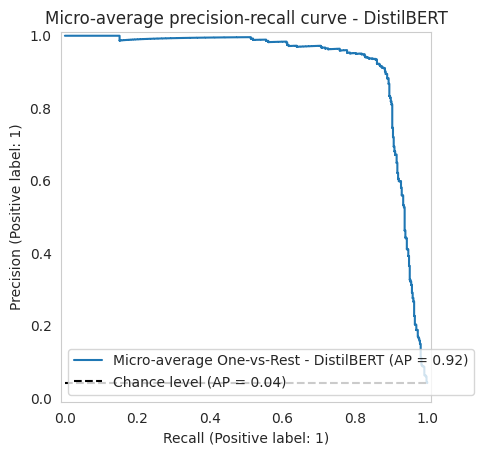

Micro-average Average Precision (DistilBERT): 0.921
Macro-average Average Precision (DistilBERT): 0.879


In [53]:
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
y_test_binarized_hf = label_binarize(test_labels, classes=np.arange(len(le.classes_)))
plt.figure(figsize=(10, 8))
avg_precisions_hf = {}

for i, class_name in enumerate(le.classes_):
    y_true_binary = (test_labels == i).astype(int)
    y_score_class = logits[:, i]
    precision, recall, _ = precision_recall_curve(y_true_binary, y_score_class)
    ap = average_precision_score(y_true_binary, y_score_class)
    avg_precisions_hf[class_name] = ap
    plt.plot(recall, precision, label=f'Class {class_name} (AP = {ap:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curves (One-vs-Rest) - DistilBERT')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nAverage Precision (AP) for each class (DistilBERT):")
for class_name, ap_score in avg_precisions_hf.items():
    print(f"  {class_name}: {ap_score:.3f}")

display_micro_hf = PrecisionRecallDisplay.from_predictions(
    y_test_binarized_hf.ravel(),
    logits.ravel(),
    name="Micro-average One-vs-Rest - DistilBERT",
    plot_chance_level=True
)
display_micro_hf.ax_.grid(False)
_ = display_micro_hf.ax_.set_title("Micro-average precision-recall curve - DistilBERT")
plt.show()

micro_avg_ap_hf = average_precision_score(y_test_binarized_hf, logits, average='micro')
macro_avg_ap_hf = np.mean(list(avg_precisions_hf.values()))

print(f"Micro-average Average Precision (DistilBERT): {micro_avg_ap_hf:.3f}")
print(f"Macro-average Average Precision (DistilBERT): {macro_avg_ap_hf:.3f}")

In [46]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "Naive Bayes": MultinomialNB(alpha=best_alpha),
    "Linear SVM": LinearSVC(random_state=42),
    "XGBoost": XGBClassifier(
        objective='multi:softprob',
        num_class=len(le.classes_),
        learning_rate=0.15,
        max_depth=8,
        n_estimators=300,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        tree_method='hist',
        random_state=42,
        eval_metric='mlogloss'
    )
}

for name, model in models.items():
    scores = cross_val_score(
        model,
        X,
        data_df['Category'],
        cv=cv,
        scoring="f1_macro"
    )
    print(f"{name} 5-fold macro-F1: {scores.mean():.3f} (+/- {scores.std():.3f})")

Naive Bayes 5-fold macro-F1: 0.534 (+/- 0.015)
Linear SVM 5-fold macro-F1: 0.671 (+/- 0.018)
XGBoost 5-fold macro-F1: 0.733 (+/- 0.028)


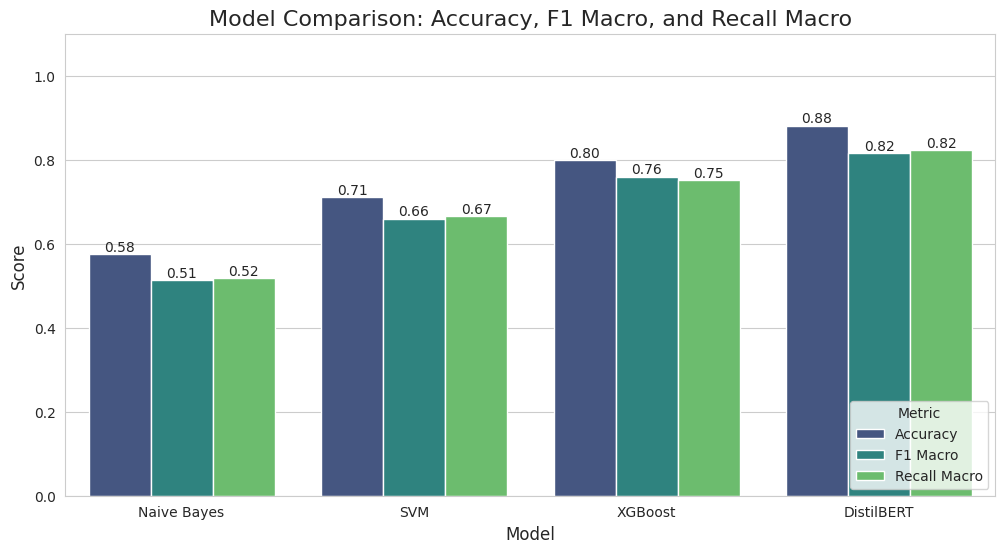

Model Performance Summary:


Model  Accuracy  F1 Macro  Recall Macro
0  Naive Bayes  0.575453  0.513640      0.518551
1          SVM  0.710262  0.659985      0.666156
2      XGBoost  0.798793  0.759512      0.751923
3   DistilBERT  0.881288  0.815201      0.822386

In [55]:
from IPython.display import display
nb_acc = accuracy_score(y_test, y_pred_tuned)
nb_f1 = f1_score(y_test, y_pred_tuned, average='macro')
nb_recall = recall_score(y_test, y_pred_tuned, average='macro')

svm_acc = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm, average='macro')
svm_recall = recall_score(y_test, y_pred_svm, average='macro')

xgb_acc = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb, average='macro')
xgb_recall = recall_score(y_test, y_pred_xgb, average='macro')

bert_acc = accuracy_score(test_labels, y_pred_hf)
bert_f1 = f1_score(test_labels, y_pred_hf, average='macro')
bert_recall = recall_score(test_labels, y_pred_hf, average='macro')

comparison_df = pd.DataFrame({
    'Model': ['Naive Bayes', 'SVM', 'XGBoost', 'DistilBERT'],
    'Accuracy': [nb_acc, svm_acc, xgb_acc, bert_acc],
    'F1 Macro': [nb_f1, svm_f1, xgb_f1, bert_f1],
    'Recall Macro': [nb_recall, svm_recall, xgb_recall, bert_recall]
})

comparison_melted = comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(data=comparison_melted, x='Model', y='Score', hue='Metric', palette='viridis')

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.title('Model Comparison: Accuracy, F1 Macro, and Recall Macro', fontsize=16)
plt.ylim(0, 1.1)
plt.ylabel('Score', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.legend(loc='lower right', title='Metric')
plt.show()
print("Model Performance Summary:")
display(comparison_df)